## TODO:
 * Give each film a notion of quality
 * Give each user a baseline rating: to emulate how some users rate higher than others
 * Implement different user behaviors in response to recommendations

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from scipy.sparse.linalg import svds
from IPython.display import display

## Setup

We have two types of movies, type 1 and type 2. Each movie has a vector assciotated with them, [x,y]. x and y are binary variables with possible values of 0 and 1. x = 1 means that the film is of type 1, and y = 1 means that the film is of type2.
Each user also has a hidden vector associated with him or her, [b,c], where b and c are preferences for type 1 and type 2 films respectively. $0 \leq b,c \leq 1$ and $b + c = 1$. If a user's perference for a type of film is [a,b], then this user has $a$ chance of accepting recommendations of films of type 1 and $b$ chance of accepting recommendations of films of type 2. This user will rate a film of type 1: $a*5 $

In [2]:
# Total number of film genres and maximum number
# of genres a single film may belong to
NUM_GENRES = 4
MAX_FILM_GENRES = 2

# Maximum film rating (e.g. 5 uses the rating scale 0-5)
MAX_RATING = 5

# Higher values = stronger user genre preferences
# Use higher values with higher NUM_GENRES values
# Reasonable values are probably b/w 0.1 and 10
USER_POLARIZATION_STRENGTH = 1

def generate_users(number_of_users):
    """
    Generate a user matrix, where each row of the
    matrix stores the properties of a user:
    [genre1_preference, ..., genreN_preference]
    
    The genre preferences of each user sum to 1.
    """
    results = []
    for i in range(number_of_users):
        user_prefs = np.random.dirichlet(
                np.ones(NUM_GENRES)/USER_POLARIZATION_STRENGTH, size=1)[0]
        results.append(user_prefs)
    return np.array(results)

def generate_films(number_of_films):
    """
    Generate a film matrix, where each row of the
    matrix represents the properties of a film:
    [is_genre1, ..., is_genreN]
    
    The is_genre values will either be 0 or 1.
    """
    results = []
    for i in range(number_of_films):
        film_genres = np.zeros(NUM_GENRES)
        film_genres[random.sample(np.arange(NUM_GENRES), 
                random.randint(1, MAX_FILM_GENRES))] = 1
        results.append(film_genres)
    return np.array(results)

In [3]:
def get_user_film_compatibility(userID, filmID):
    """
    Returns a value between 0 and 1 indicating how much
    a user's preferences aligns with the film's genre(s).
    """
    user_prefs = users[userID][:NUM_GENRES]
    film_genres = films[filmID][:NUM_GENRES]
    return np.sum(user_prefs * film_genres)

def generate_initial_ratings(users, films, view_rate, rescale_to_midline=False):
    """
    Generates a (num_films, num_users) rating matrix, where
    each row represents the ratings that film has received
    from all users.
    
    view_rate is the chance a user will view a given film.
    
    If rescale_to_midline is True, the ratings are scaled
    such that mean of non-zero ratings is MAX_RATING / 2.
    """
    results = []
    for filmID in range(films.shape[0]):
        film_ratings = []
        for userID in range(users.shape[0]):
            ran = random.uniform(0,1)
            if (ran <= view_rate):
                rating = MAX_RATING * get_user_film_compatibility(userID, filmID)
                film_ratings.append(rating)
            else:
                film_ratings.append(0)
        results.append(film_ratings)
    results = np.array(results)
    # Perform rescaling if necessary
    if rescale_to_midline:
        results = results * ((MAX_RATING / 2.0) / (results[results.nonzero()].mean()))
        results = np.clip(results, 0, MAX_RATING)
    return results

In [4]:
NUM_USERS = 6040 # 6040
NUM_FILMS = 3883 # 3883
INITIAL_VIEWING_RATE = 0.05 # 0.05
RESCALE_TO_MIDLINE = True

users = generate_users(NUM_USERS)
films = generate_films(NUM_FILMS)
initial_ratings = generate_initial_ratings(users, films,
        INITIAL_VIEWING_RATE, rescale_to_midline=RESCALE_TO_MIDLINE)

compats = []
sample_userIDs = random.sample(np.arange(NUM_USERS), min(500, NUM_USERS))
sample_filmIDs = random.sample(np.arange(NUM_FILMS), min(500, NUM_FILMS))
for userID in sample_userIDs:
    for filmID in sample_filmIDs:
        compats.append(get_user_film_compatibility(userID, filmID))
mean_compatibility = 1.0 * sum(compats) / len(compats)
max_abs_compatibility = max(max(compats), abs(min(compats)))

print("Mean compatibility: %f" % mean_compatibility)
print("Max absolute compatibility: %f" % max_abs_compatibility)
display(initial_ratings)
print(initial_ratings.shape)

Mean compatibility: 0.366729
Max absolute compatibility: 0.988989


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 2.00081202,
        0.        ],
       [0.        , 0.        , 3.2917405 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.38744713, ..., 0.        , 0.        ,
        0.        ]])

(3883, 6040)


In [5]:
# The number of singular values to compute with SVD
# Larger values give more accurate predictions, but
# take longer to compute (and give longer simulator
# convergence times)
# Reasonable values are probably b/w 10 and 50
K_VAL = 10

def get_predicted_ratings(actual_ratings):
    """
    Returns a (num_users, num_films) matrix containing
    the predicted ratings each user would each film.
    """
    # Only consider non-zero ratings when calculating the mean
    masked_user_ratings = np.ma.masked_equal(initial_ratings.T, 0)
    user_ratings_mean = masked_user_ratings.mean(axis=1).data
    # Calculate SVD values of demeaned ratings + estimate new ratings
    R_demeaned = actual_ratings.T - user_ratings_mean.reshape(-1, 1)
    U, sigma, Vt = svds(R_demeaned, k=K_VAL)
    sigma = np.diag(sigma)
    predicted_ratings = np.round(np.dot(np.dot(U, sigma), Vt) +
            user_ratings_mean.reshape(-1, 1))
    return predicted_ratings

example_predictions = get_predicted_ratings(initial_ratings)
display(example_predictions)
print(example_predictions.shape)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

(6040, 3883)


Question: Should we also recommend videos that users have already viewed? At least for me, Youtube recommends videos that I have already watched all the time.

In [6]:
def get_recommendations(predicted_ratings, userID, num_recommendations=5):
    """
    Returns the filmIDs of the top num_recommendations
    film recommendations for the user with the userID.
    """
    predicted_user_ratings = predicted_ratings[userID]
    recommendations = np.argsort(predicted_user_ratings)[-num_recommendations:]
    return recommendations

def give_recommendations(predicted_ratings, userID):
    """
    Recommends films to the user, and returns a tuple
    containing the recommended film IDs, and counts
    of the recommendations received of each film genre.
    """
    recommended_filmIDs = get_recommendations(predicted_ratings, userID).tolist()
    film_recs = films[recommended_filmIDs, :]
    genre_counts = [int(sum(film_recs[:, genre_idx]))
            for genre_idx in range(NUM_GENRES)]
    return (recommended_filmIDs, genre_counts)

example_recs = give_recommendations(example_predictions, 0)
print("Example Film Recommendations: " + str(example_recs[0]))
print("Example Distribution: " + str(example_recs[1]))

Example Film Recommendations: [1300, 1301, 1302, 1274, 3882]
Example Distribution: [0, 4, 1, 2]


## Run the Simulation:

In [7]:
initial_predictions = get_predicted_ratings(initial_ratings)

# A (num_users, num_genres) matrix where each row
# is the number of recommendations that user has
# received of each film genre
initial_distribution_matrix = []

# Get the initial recommendation genre distribution
for userID in range(users.shape[0]):
    (recommended_filmIDs, type_counts) = give_recommendations(initial_predictions, userID)
    initial_distribution_matrix.append(type_counts)

display(initial_distribution_matrix[:10])

[[0, 4, 1, 2],
 [0, 4, 1, 2],
 [0, 4, 1, 2],
 [0, 4, 1, 2],
 [0, 5, 0, 5],
 [0, 4, 1, 2],
 [3, 3, 4, 0],
 [0, 4, 1, 2],
 [1, 1, 3, 4],
 [0, 4, 1, 2]]

In [8]:
# Determines how much a user's compatibility with 
# the film affects the final rating. The final
# rating given will be mean_rating + [-CRS, +CRS]
COMPATIBILITY_RATING_STRENGTH = 1

def step_simulation(actual_ratings, predicted_ratings,
                    rec_genre_counts, verbose=False):
    """
    Runs one step of the simulation:
    
    Gives new recommendations to each user, and simulates them
    viewing + rating a random selection of them.
    
    Returns the new rating matrix, the new distribution matrix of
    recommended film genres, and the # of changes in this matrix.
    
    If verbose is True, prints extra debugging information.
    """
    new_ratings = actual_ratings.copy()
    new_distribution_matrix = []
    num_distribution_changes = 0
    
    for userID in range(users.shape[0]):
        user = users[userID]
        (recommended_filmIDs, new_genre_counts) = \
                give_recommendations(predicted_ratings, userID)
        new_distribution_matrix.append(new_genre_counts)
        
        # Check for changes in the user's recommendation distribution
        if (new_genre_counts[0] != rec_genre_counts[userID][0]) or \
                (new_genre_counts[1] != rec_genre_counts[userID][1]):
            num_distribution_changes += 1
        
        # Determine whether the user will watch each
        # recommended film, and assign a rating if so
        for filmID in recommended_filmIDs:
            compatibility = get_user_film_compatibility(userID, filmID)
            ran = random.uniform(0,1)
            if ran <= compatibility:
                film_ratings = actual_ratings[:, filmID]
                mean_rating = np.mean(film_ratings[film_ratings.nonzero()])
                # Convert user-film compatibility into a value from -CRS to CRS
                compat_influence = ((compatibility - mean_compatibility)
                        / max_abs_compatibility) * COMPATIBILITY_RATING_STRENGTH
                rating = max(min(round(mean_rating + compat_influence), MAX_RATING), 0)
                new_ratings[filmID, userID] = rating

    return (new_ratings, new_distribution_matrix, num_distribution_changes)

In [9]:
MAX_STEPS = 200
CHANGE_THRESHOLD = 0
VERBOSE = False

ratings = initial_ratings.copy()
predictions = initial_predictions.copy()
rec_distribution = list(initial_distribution_matrix)
num_changes_over_time = []

for step in range(MAX_STEPS):
    predictions = get_predicted_ratings(ratings)
    ratings, rec_distribution, num_changes = step_simulation(ratings,
            predictions, rec_distribution, verbose=VERBOSE)
    num_changes_over_time.append(num_changes)
    if step > 0 and num_changes <= CHANGE_THRESHOLD:
        print("Convergence!")
        break
    print("Step #%d: Num Changes = %d" % (step, num_changes))

Step #0: Num Changes = 0
Step #1: Num Changes = 3852
Step #2: Num Changes = 4700
Step #3: Num Changes = 4452
Step #4: Num Changes = 4045
Step #5: Num Changes = 3403
Step #6: Num Changes = 2876
Step #7: Num Changes = 2472
Step #8: Num Changes = 2134
Step #9: Num Changes = 1929
Step #10: Num Changes = 1638
Step #11: Num Changes = 1495
Step #12: Num Changes = 1268
Step #13: Num Changes = 1091
Step #14: Num Changes = 1005
Step #15: Num Changes = 837
Step #16: Num Changes = 761
Step #17: Num Changes = 658
Step #18: Num Changes = 626
Step #19: Num Changes = 608
Step #20: Num Changes = 502
Step #21: Num Changes = 439
Step #22: Num Changes = 386
Step #23: Num Changes = 370
Step #24: Num Changes = 367
Step #25: Num Changes = 306
Step #26: Num Changes = 281
Step #27: Num Changes = 249
Step #28: Num Changes = 237
Step #29: Num Changes = 208
Step #30: Num Changes = 184
Step #31: Num Changes = 233
Step #32: Num Changes = 168
Step #33: Num Changes = 151
Step #34: Num Changes = 155
Step #35: Num Chan

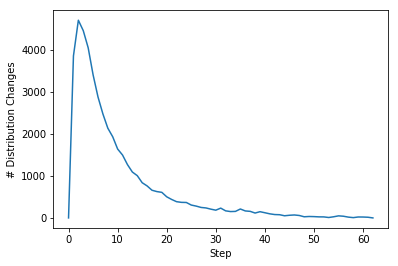

In [10]:
# Plot the recommendation distribution changes over time
plt.plot(num_changes_over_time)
plt.xlabel("Step")
plt.ylabel("# Distribution Changes")
plt.show()